## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [224]:
import pandas as pd
import numpy as np

In [225]:
#загрузим данные 

df=pd.read_csv("data.adult.csv",sep=',')

In [226]:
#посмотрим на их описание

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [227]:
#посмотрим данные

df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [228]:
# Найдем все признаки, имеющие пропущенные значения. Удалим из выборки все объекты с пропусками

df.replace(to_replace='?', value=np.nan, inplace=True)

In [229]:
df.dropna(axis=0,inplace=True)

In [230]:
# выделяем целевую переменную в отдельную переменную y, удалять ее из датасета не будем (чтобы видить исходные данные)
# но скопируем данные объектов без нее в новую переменную
# y преобразуем к бинарному формату.

y=df[['>50K,<=50K']]
y = (y == '>50K').astype(int)


In [231]:
# проверим
y.dtypes

>50K,<=50K    int32
dtype: object

In [232]:
#найдем вещественные признаки и запишем в X

num_cols=df.columns[df.dtypes == 'int64'].tolist()
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [233]:
X=df[num_cols]

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [234]:
#оптимизация гиперпараметра 'n_neighbors' для KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

grid={'n_neighbors': np.arange(1, 50, 1)}

model_knn=KNeighborsClassifier()
grid_knn=GridSearchCV(model_knn,grid,cv=5,scoring='roc_auc')
grid_knn.fit(X,y.values.ravel())

print(grid_knn.best_estimator_)
print(grid_knn.best_score_)

KNeighborsClassifier(n_neighbors=4)
0.6407170629127037


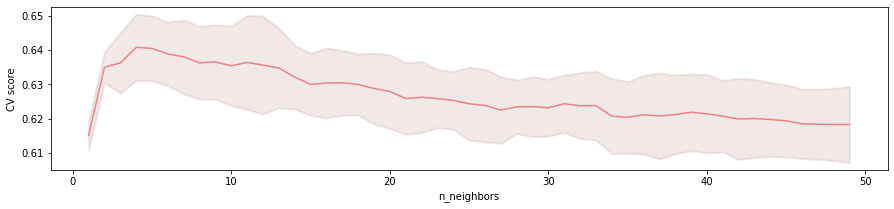

In [235]:
# построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, 
# на котором также отобразим доверительный интервал

import matplotlib.pyplot as plt

plt.figure(1, figsize=(15, 3))
plt.clf()

C_s = grid_knn.cv_results_['param_n_neighbors'].data
scores = grid_knn.cv_results_['mean_test_score']
scores_std = grid_knn.cv_results_['std_test_score']
minus=scores - scores_std
plus=scores + scores_std
plt.plot(C_s, scores,color='lightcoral')
plt.fill_between(C_s.astype(float), minus, plus,color='rosybrown', lw=2,alpha=0.2)
plt.ylabel('CV score')
plt.xlabel('n_neighbors')
plt.show()

In [236]:
# оптимизация гиперпараметра 'loss' для SGDClassifier

from sklearn.linear_model import SGDClassifier

grid={'loss':['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}

model_SGD=SGDClassifier()
grid_SGD=GridSearchCV(model_SGD,grid,cv=5,scoring='roc_auc')
grid_SGD.fit(X,y.values.ravel())

print(grid_SGD.best_estimator_)
print(grid_SGD.best_score_)

SGDClassifier(loss='squared_hinge')
0.6177900744608026


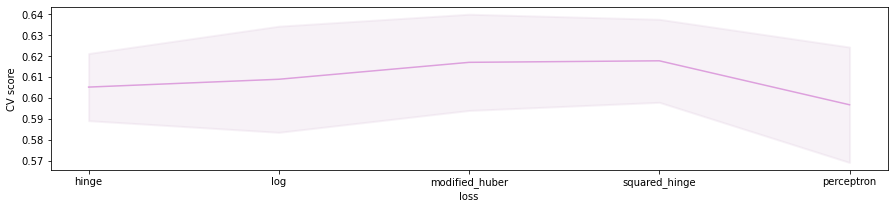

In [237]:
# построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, 
# на котором также отобразим доверительный интервал

plt.figure(1, figsize=(15, 3))
plt.clf()

C_s = grid_SGD.cv_results_['param_loss'].data
scores = grid_SGD.cv_results_['mean_test_score']
scores_std = grid_SGD.cv_results_['std_test_score']
minus=scores - scores_std
plus=scores + scores_std
plt.plot(C_s, scores,color='plum')
plt.fill_between(C_s, minus, plus,color='thistle', lw=2,alpha=0.2)
plt.ylabel('CV score')
plt.xlabel('loss')
plt.show()

Что вы можете сказать о получившихся графиках?

Вывод

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

In [238]:
# оптимизация гиперпараметра 'C' для LogisticRegression

from sklearn.linear_model import LogisticRegression

grid = {'C': [0.001,0.01,0.1,1,10,100,1000]}

model_LR=LogisticRegression()
grid_lr=GridSearchCV(model_LR,grid,cv=5,scoring='roc_auc')
grid_lr.fit(X,y.values.ravel())

print(grid_lr.best_estimator_)
print(grid_lr.best_score_)

LogisticRegression(C=0.001)
0.5741676816073445


In [239]:
# оптимизация гиперпараметра 'C' для LinearSVC

from sklearn.svm import LinearSVC

grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

model_SVC=LinearSVC() 
grid_SVC=GridSearchCV(model_SVC,grid,cv=5,scoring='roc_auc')
grid_SVC.fit(X,y.values.ravel())

print(grid_SVC.best_estimator_)
print(grid_SVC.best_score_)

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

LinearSVC(C=1e-05)
0.5796550086573504


C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

In [240]:
# оптимизация гиперпараметра 'var_smoothing' для GaussianNB

from sklearn.naive_bayes import GaussianNB

param = {'var_smoothing': np.logspace(0,-9, num=100)}

model_nb=GaussianNB()
grid_nb=GridSearchCV(model_nb,param,cv=5,scoring='roc_auc')
grid_nb.fit(X,y.values.ravel())

print(grid_nb.best_params_)
print(grid_nb.best_score_)

{'var_smoothing': 1e-09}
0.8169743354842621


При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

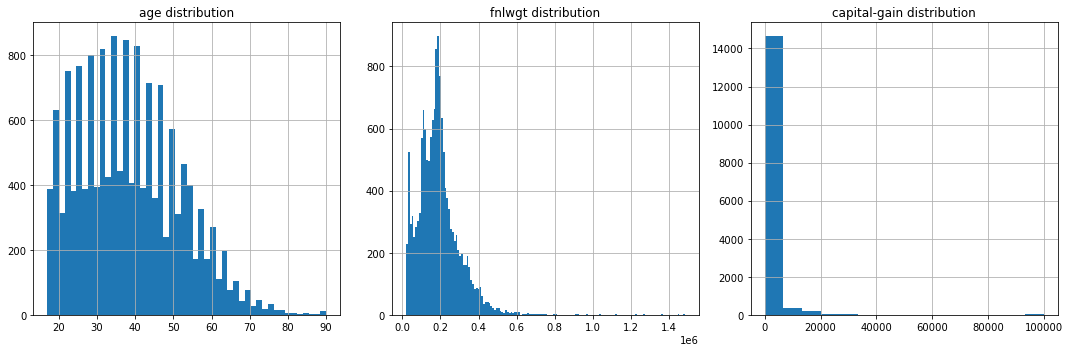

In [241]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 5))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins='auto',ax=ax)
        ax.set_title(var_name+" distribution")
    fig.tight_layout()  
    plt.show()

test =X[['age', 'fnlwgt', 'capital-gain']] 
draw_histograms(test, test.columns, 1, 3)

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

In [242]:
# масштабируем признаки и подберем гиперпараметр 'var_smoothing' для модели GaussianNB()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GaussianNB())])

grid = {'model__var_smoothing': np.logspace(0,-9, num=100)}

grid = GridSearchCV(pipe, grid, cv=5,scoring='roc_auc')
grid.fit(X, y.values.ravel())

print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GaussianNB(var_smoothing=0.12328467394420659))])
0.8308977066738171


In [243]:
# масштабируем признаки и подберем гиперпараметр 'C' для модели LinearSVC()

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearSVC())])

grid = {'model__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}

grid = GridSearchCV(pipe, grid, cv=5,scoring='roc_auc')
grid.fit(X, y.values.ravel())

print(grid.best_estimator_)
print(grid.best_score_)

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearSVC(C=0.01))])
0.8244962941126254


C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [244]:
# масштабируем признаки и подберем гиперпараметр 'C' для модели LogisticRegression()

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression())])

grid = {'model__C': [0.001,0.01,0.1,1,10,100,1000]}

grid = GridSearchCV(pipe, grid, cv=5,scoring='roc_auc')
grid.fit(X, y.values.ravel())

print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.1))])
0.8251377771828248


In [245]:
# масштабируем признаки и подберем гиперпараметр 'loss' для модели SGDClassifier()

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SGDClassifier())])

grid = {'model__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']}

grid = GridSearchCV(pipe, grid, cv=5,scoring='roc_auc')
grid.fit(X, y.values.ravel())

print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SGDClassifier(loss='log'))])
0.8193059197614373


In [246]:
# масштабируем признаки и подберем гиперпараметр 'loss' для модели KNeighborsClassifier()

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())])

grid={'model__n_neighbors': np.arange(1, 50, 1)}

grid = GridSearchCV(pipe, grid, cv=5,scoring='roc_auc')
grid.fit(X, y.values.ravel())

print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=38))])
0.8342253274543113


In [247]:
#сохраним нормированные данные ЭТО НЕПРАВИЛЬНО НУУЖНО разные выборки

scaler=StandardScaler().fit(X)
X_sc=scaler.transform(X)

Изменилось ли качество у некоторых алгоритмов?

Вывод

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

In [248]:
from datetime import datetime
import time

In [249]:
#создадим таблицу для результатов
columns = ['Model','Parameters','Score', 'Time','OHC','Norm','Mean_test_score','Std_test_score']
result=pd.DataFrame(columns=columns)
result

,Model,Parameters,Score,Time,OHC,Norm,Mean_test_score,Std_test_score


In [250]:
# масштабируем признаки и подберем гиперпараметры 'n_neighbors' и 'metric' для модели KNeighborsClassifier()
# количество значений 'metric' намерено сокращено (тк пришлось бы делать отдельные наборы для зависимых гиперпараметров,
# дальше я сделаю пример с зависимыми парами)

neighbors = np.arange(1, 50, 1)
grid = {'n_neighbors': neighbors,
        'metric':['euclidean','manhattan','chebyshev','minkowski']}

model_knn=KNeighborsClassifier()

grid_knn=GridSearchCV(model_knn,grid,cv=5,scoring='roc_auc')

start_time = datetime.now()
%time grid_knn.fit(X_sc,y.values.ravel())
vrem=datetime.now() - start_time

print(grid_knn.best_estimator_)
print(grid_knn.best_score_)
result.loc[len(result)+1] = ['KNeighborsClassifier',grid_knn.best_estimator_,grid_knn.best_score_,vrem,0,1,grid_knn.cv_results_['mean_test_score'],grid_knn.cv_results_['std_test_score']]

Wall time: 5min 36s
KNeighborsClassifier(metric='manhattan', n_neighbors=41)
0.8344509490927339


In [251]:
# масштабируем признаки и подберем гиперпараметр 'loss' и 'penalty' для модели SGDClassifier()

model_SGD=SGDClassifier()

grid = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
       'penalty': ['l2', 'l1', 'elasticnet']}

grid_SGD = GridSearchCV(model_SGD, grid, cv=5,scoring='roc_auc')

start_time = datetime.now()
%time grid_SGD.fit(X_sc, y.values.ravel())
vrem=datetime.now() - start_time

print(grid_SGD.best_params_)
print(grid_SGD.best_score_)
result.loc[len(result)+1] = ['SGDClassifier',grid_SGD.best_estimator_,grid_SGD.best_score_,vrem,0,1,grid_SGD.cv_results_['mean_test_score'],grid_SGD.cv_results_['mean_test_score']]

Wall time: 4.86 s
{'loss': 'log', 'penalty': 'l1'}
0.8216511301891674


In [252]:
result

,Model,Parameters,Score,Time,OHC,Norm,Mean_test_score,Std_test_score
1,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.834451,00:05:36.475273,0,1,"[0.6661758739706396, 0.7247047732555478, 0.752...","[0.009314812823255999, 0.007914753976097182, 0..."
2,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.821651,00:00:04.865232,0,1,"[0.7923512898761016, 0.8104999254441545, 0.803...","[0.7923512898761016, 0.8104999254441545, 0.803..."


In [253]:
# масштабируем признаки и подберем гиперпараметры для модели LogisticRegression()
# тк гиперпараметры зависят друг от друга, возьмем несколько комбинаций

model_LR=LogisticRegression()

grid = [{'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], 'penalty': ['l1'],'class_weight':[None,'balanced'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], 'penalty': ['l2'],'class_weight':[None,'balanced'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}]
                                                                                    
grid_LR = GridSearchCV(model_LR, grid, cv=5,scoring='roc_auc')

start_time = datetime.now()
%time grid_LR.fit(X_sc, y.values.ravel())
vrem=datetime.now() - start_time

print(grid_LR.best_estimator_)
print(grid_LR.best_score_)
result.loc[len(result)+1] = ['LogisticRegression',grid_LR.best_estimator_,grid_LR.best_score_,vrem,0,1,grid_LR.cv_results_['mean_test_score'],grid_LR.cv_results_['std_test_score']]

Wall time: 8.4 s
LogisticRegression(C=0.1, class_weight='balanced', multi_class='ovr')
0.8257333964911284


In [254]:
# масштабируем признаки и подберем гиперпараметры для модели LinearSVC()

model_SVC=LinearSVC(dual=False) 

grid = [{'C': [0.001,0.01,0.1,1,10,100,1000], 'penalty': ['l1','l2'],'loss' : ['squared_hinge'] , 'multi_class': ['ovr'], 'class_weight':[None,'balanced']}]

grid_SVC = GridSearchCV(model_SVC, grid, cv=5,scoring='roc_auc')

start_time = datetime.now()
%time grid_SVC.fit(X_sc, y.values.ravel())
vrem=datetime.now() - start_time

print(grid_SVC.best_estimator_)
print(grid_SVC.best_score_)
result.loc[len(result)+1] = ['LinearSVC',grid_SVC.best_estimator_,grid_SVC.best_score_,vrem,0,1,grid_SVC.cv_results_['mean_test_score'],grid_SVC.cv_results_['std_test_score']]

Wall time: 2.11 s
LinearSVC(C=1000, class_weight='balanced', dual=False, penalty='l1')
0.8256082413217506


In [319]:
# масштабируем признаки и подберем гиперпараметр 'var_smoothing' для модели GaussianNB()
#!!!!!!!!!!!!!!!!!!!!!!!!другие
grid = {'var_smoothing': np.logspace(0,-9, num=100)}
model_nb=GaussianNB()
grid_nb=GridSearchCV(model_nb,grid,cv=5,scoring='roc_auc')

start_time = datetime.now()
%time grid_nb.fit(X_sc,y.values.ravel())
vrem=datetime.now() - start_time

print(grid_nb.best_estimator_)
print(grid_nb.best_score_)
print(grid_nb.cv_results_)
result.loc[len(result)+1] = ['GaussianNB',grid_nb.best_estimator_,grid_nb.best_score_,vrem,0,1,grid_nb.cv_results_['mean_test_score'],grid_nb.cv_results_['std_test_score']]

Wall time: 2.99 s
GaussianNB(var_smoothing=0.12328467394420659)
0.8308654407329719
{'mean_fit_time': array([0.00539975, 0.00540147, 0.00378237, 0.00130968, 0.00624843,
       0.00312662, 0.00312262, 0.003125  , 0.00313377, 0.00312791,
       0.00624995, 0.00313048, 0.00312033, 0.00312629, 0.00312419,
       0.        , 0.00312471, 0.        , 0.00625143, 0.0031466 ,
       0.00626106, 0.00312591, 0.00312543, 0.00311804, 0.00312462,
       0.00624957, 0.00312448, 0.        , 0.00312672, 0.003124  ,
       0.        , 0.00312347, 0.        , 0.00312386, 0.        ,
       0.0047503 , 0.0032166 , 0.00312743, 0.00312443, 0.00312552,
       0.        , 0.00312438, 0.00312443, 0.00280018, 0.00379353,
       0.00102062, 0.00625248, 0.00312524, 0.        , 0.00312486,
       0.00312371, 0.00625029, 0.        , 0.00650172, 0.00624957,
       0.        , 0.0031239 , 0.00312734, 0.00624952, 0.00043173,
       0.00313721, 0.00312791, 0.006251  , 0.        , 0.00312352,
       0.00311651, 0.0062522

In [317]:
type(grid_nb.cv_results_['mean_test_score'])

numpy.ndarray

In [318]:
grid_nb.cv_results_['mean_test_score']

array([0.82190693, 0.82327489, 0.82467079, 0.82594474, 0.8271276 ,
       0.82829789, 0.82921252, 0.8299516 , 0.83048275, 0.83079291,
       0.83086544, 0.83076915, 0.83045491, 0.8300535 , 0.82963756,
       0.82919687, 0.8287703 , 0.8283271 , 0.82791861, 0.82751289,
       0.82711913, 0.82674823, 0.826415  , 0.82612521, 0.82588798,
       0.82568779, 0.82551192, 0.82536396, 0.82524649, 0.8251358 ,
       0.82504664, 0.82497099, 0.82491148, 0.82485324, 0.82480886,
       0.82477443, 0.82474745, 0.8247203 , 0.82470328, 0.82468949,
       0.8246748 , 0.82466034, 0.82465055, 0.82464338, 0.82463609,
       0.8246312 , 0.82462753, 0.82462435, 0.82462168, 0.8246189 ,
       0.82461657, 0.8246154 , 0.8246144 , 0.82461429, 0.82461362,
       0.82461329, 0.82461262, 0.8246124 , 0.82461229, 0.82461195,
       0.82461206, 0.82461195, 0.82461195, 0.82461162, 0.8246114 ,
       0.8246114 , 0.8246114 , 0.8246114 , 0.8246114 , 0.8246114 ,
       0.8246114 , 0.82461128, 0.82461128, 0.82461128, 0.82461

Какой из алгоритмов имеет наилучшее качество? 

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [256]:
#посмотрим на все нечисловые признаки
for i in df.columns:
    if (df[i].dtype == np.object and i!='>50K,<=50K'):
          print(i+':')
          print(set(df[i]))

workclass:
{'Private', 'Local-gov', 'Self-emp-inc', 'Without-pay', 'State-gov', 'Federal-gov', 'Self-emp-not-inc'}
education:
{'HS-grad', 'Doctorate', '7th-8th', '9th', 'Prof-school', '5th-6th', 'Assoc-acdm', '1st-4th', '10th', 'Some-college', 'Masters', '12th', '11th', 'Assoc-voc', 'Preschool', 'Bachelors'}
marital-status:
{'Separated', 'Never-married', 'Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Widowed', 'Married-spouse-absent'}
occupation:
{'Farming-fishing', 'Machine-op-inspct', 'Priv-house-serv', 'Other-service', 'Prof-specialty', 'Protective-serv', 'Craft-repair', 'Sales', 'Adm-clerical', 'Transport-moving', 'Tech-support', 'Handlers-cleaners', 'Exec-managerial', 'Armed-Forces'}
relationship:
{'Other-relative', 'Unmarried', 'Not-in-family', 'Husband', 'Wife', 'Own-child'}
race:
{'Asian-Pac-Islander', 'White', 'Amer-Indian-Eskimo', 'Black', 'Other'}
sex:
{'Male', 'Female'}


In [257]:
# сделаем OneHotCoding с удалением одного столбца в группе, чтобы не было зависимых признаков

obj_cols=df.columns[df.dtypes == np.object].tolist()
data=df[obj_cols[:len(obj_cols)-1]]
data = pd.get_dummies(data, drop_first=True)

In [258]:
data

,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_11th,education_12th,education_1st-4th,education_5th-6th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
16276,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
16277,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
16278,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [259]:
X_full = pd.DataFrame(data=X_sc, columns=['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week'])

In [260]:
data.reset_index(drop=True,inplace=True)

In [261]:
data_sc_ohc=X_full.join(data)

In [262]:
data_sc_ohc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15347 entries, 0 to 15346
Data columns (total 56 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   15347 non-null  float64
 1   fnlwgt                                15347 non-null  float64
 2   education-num                         15347 non-null  float64
 3   capital-gain                          15347 non-null  float64
 4   capital-loss                          15347 non-null  float64
 5   hours-per-week                        15347 non-null  float64
 6   workclass_Local-gov                   15347 non-null  uint8  
 7   workclass_Private                     15347 non-null  uint8  
 8   workclass_Self-emp-inc                15347 non-null  uint8  
 9   workclass_Self-emp-not-inc            15347 non-null  uint8  
 10  workclass_State-gov                   15347 non-null  uint8  
 11  workclass_Witho

In [270]:
result

,Model,Parameters,Score,Time,OHC,Norm,Mean_test_score,Std_test_score
1,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.834451,00:05:36.475273,0,1,"[0.6661758739706396, 0.7247047732555478, 0.752...","[0.009314812823255999, 0.007914753976097182, 0..."
2,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.821651,00:00:04.865232,0,1,"[0.7923512898761016, 0.8104999254441545, 0.803...","[0.7923512898761016, 0.8104999254441545, 0.803..."
3,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.825733,00:00:08.400102,0,1,"[0.5, 0.5, 0.5, 0.5, 0.7730420620964141, 0.788...","[0.0, 0.0, 0.0, 0.0, 0.00332757902673906, 0.00..."
4,LinearSVC,"LinearSVC(C=1000, class_weight='balanced', dua...",0.825608,00:00:02.115999,0,1,"[0.8218992831946761, 0.824170125258755, 0.8196...","[0.003583900702052512, 0.0038912635855560228, ..."
5,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.830865,00:00:03.106524,0,1,"[0.8219069260172608, 0.8232748922285659, 0.824...","[0.0041397340978801545, 0.004083357535711593, ..."


In [274]:
a1=cross_val_score(GaussianNB(var_smoothing=0.12328467394420659), data_sc_ohc, y.values.ravel(), cv=5, scoring='roc_auc')
result.loc[len(result)+1] = ['GaussianNB',grid_nb.best_estimator_,a1.mean(),np.nan,1,1,a1,np.nan]

a2=cross_val_score(KNeighborsClassifier(metric='manhattan', n_neighbors=41), data_sc_ohc, y.values.ravel(), cv=5, scoring='roc_auc')
result.loc[len(result)+1] = ['KNeighborsClassifier',grid_knn.best_estimator_,a2.mean(),np.nan,1,1,a2,np.nan]

a3=cross_val_score(SGDClassifier(loss='log', penalty='l2'), data_sc_ohc, y.values.ravel(), cv=5, scoring='roc_auc')
result.loc[len(result)+1] = ['SGDClassifier',grid_SGD.best_estimator_,a3.mean(),np.nan,1,1,a3,np.nan]

a4=cross_val_score(LogisticRegression(C=0.1, class_weight='balanced',max_iter=1000, multi_class='ovr'), data_sc_ohc, y.values.ravel(), cv=5, scoring='roc_auc')
result.loc[len(result)+1] = ['LogisticRegression',grid_LR.best_estimator_,a4.mean(),np.nan,1,1,a4,np.nan]

a5=cross_val_score(LinearSVC(C=1000, class_weight='balanced', dual=False, penalty='l1'), data_sc_ohc, y.values.ravel(), cv=5, scoring='roc_auc')
result.loc[len(result)+1] = ['LinearSVC',grid_SVC.best_estimator_,a5.mean(),np.nan,1,1,a5,np.nan]

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

In [275]:
result

,Model,Parameters,Score,Time,OHC,Norm,Mean_test_score,Std_test_score
1,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.834451,0 days 00:05:36.475273,0,1,"[0.6661758739706396, 0.7247047732555478, 0.752...","[0.009314812823255999, 0.007914753976097182, 0..."
2,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.821651,0 days 00:00:04.865232,0,1,"[0.7923512898761016, 0.8104999254441545, 0.803...","[0.7923512898761016, 0.8104999254441545, 0.803..."
3,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.825733,0 days 00:00:08.400102,0,1,"[0.5, 0.5, 0.5, 0.5, 0.7730420620964141, 0.788...","[0.0, 0.0, 0.0, 0.0, 0.00332757902673906, 0.00..."
4,LinearSVC,"LinearSVC(C=1000, class_weight='balanced', dua...",0.825608,0 days 00:00:02.115999,0,1,"[0.8218992831946761, 0.824170125258755, 0.8196...","[0.003583900702052512, 0.0038912635855560228, ..."
5,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.830865,0 days 00:00:03.106524,0,1,"[0.8219069260172608, 0.8232748922285659, 0.824...","[0.0041397340978801545, 0.004083357535711593, ..."
6,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.892096,NaN,1,1,"[0.8879211396183774, 0.8995554482887484, 0.896...",NaN
7,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.892096,NaN,1,1,"[0.8879211396183774, 0.8995554482887484, 0.896...",NaN
8,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.890718,NaN,1,1,"[0.8887080306259092, 0.8962858188337774, 0.893...",NaN
9,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.900914,NaN,1,1,"[0.8979744368863363, 0.9043602103418056, 0.899...",NaN
10,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.903598,NaN,1,1,"[0.8994992815101188, 0.9097577821574272, 0.903...",NaN


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

Вывод:

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [276]:
#поделим данные на test и train

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(data_sc_ohc,y,random_state=35)

In [277]:
#Лучшее кажество показали модели LogisticRegression и LinearSVC
# но LinearSVC не может предсказывать вероятность классов, поэтому заменим ее на аналог SVC (kernel='linear)

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

best1=LogisticRegression(C=0.1, class_weight='balanced',max_iter=1000, multi_class='ovr')
best2= SVC(kernel='linear',probability=True)

print(best1.fit(X_train,y_train.values.ravel()))
print(best2.fit(X_train,y_train.values.ravel()))

LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000,
                   multi_class='ovr')
SVC(kernel='linear', probability=True)


In [278]:
pred1 = best1.predict(X_test)
print('best1_pred: ',roc_auc_score(pred1, y_test))

pred2 = best2.predict(X_test)
print('best2_pred: ',roc_auc_score(pred2, y_test))

best1_pred:  0.7729272796037863
best2_pred:  0.816136828132572


In [279]:
#Сделаем смешанную модель и запишим расчетные данные в словарь

from sklearn.ensemble import VotingClassifier
cv_results={'param_alfa':[],'mean_test_score':[],'std_test_score':[]}

for alpha in np.arange(0.1,1.1,0.1):
    model_vc=VotingClassifier(estimators=[('LG', best1),('SVR', best2)],voting='soft',weights=[alpha,1-alpha])
    cr_v=cross_val_score(model_vc,X_test,y_test.values.ravel(),cv=5,scoring='roc_auc').mean()
    std=cross_val_score(model_vc,X_test,y_test.values.ravel(),cv=5,scoring='roc_auc').std() 
    cv_results['param_alfa'].append(alpha)
    cv_results['mean_test_score'].append(cr_v)
    cv_results['std_test_score'].append(std)
print(cv_results)

{'param_alfa': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'mean_test_score': [0.9054143102159011, 0.9062607607228825, 0.9069100183844426, 0.9074068094380738, 0.9077705616582687, 0.9078468868377294, 0.9079373888734723, 0.9077138791485291, 0.9074744173458447, 0.9069760441650183], 'std_test_score': [0.006018291430589678, 0.005647178179019098, 0.005554063293375121, 0.0055424378968883204, 0.005493311891779677, 0.0054468682318333924, 0.005339655023746302, 0.005445389712752648, 0.005450411517791316, 0.005486536473023784]}


In [280]:
model_vc=VotingClassifier(estimators=[('LG', best1),('SVR', best2)],voting='soft',weights=[0.6,0.4])
cr_v=cross_val_score(model_vc,X_test,y_test.values.ravel(),cv=5,scoring='roc_auc')

result.loc[len(result)+1] = ['LG_SVR','alpha=0.6',cr_v.mean(),np.nan,1,1,cr_v,np.nan]


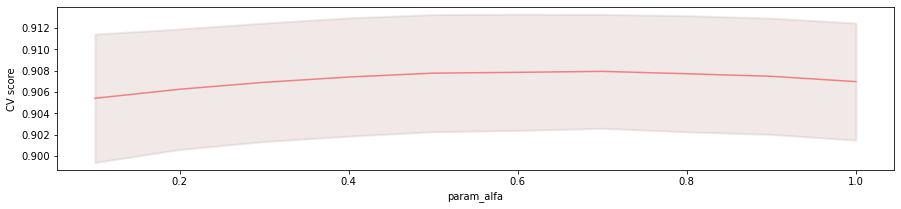

In [281]:
# построим график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, 
# на котором также отобразим доверительный интервал

plt.figure(1, figsize=(15, 3))
plt.clf()

C_s = cv_results['param_alfa']
scores = np.asarray(cv_results['mean_test_score'])
scores_std = np.asarray(cv_results['std_test_score'])
minus=scores - scores_std
plus=scores + scores_std
plt.plot(C_s, scores,color='lightcoral')
plt.fill_between(C_s, minus, plus,color='rosybrown', lw=2,alpha=0.2)
plt.ylabel('CV score')
plt.xlabel('param_alfa')
plt.show()


In [282]:
# c помощью CalibratedClassifierCV можно сделать predict_proba и в LinearSVC
# поэксперементируем..

from sklearn.calibration import CalibratedClassifierCV

model2_best=LinearSVC(C=1000, class_weight='balanced', dual=False, penalty='l1')
best3 = CalibratedClassifierCV(model2_best) 
best3.fit(X_train,y_train.values.ravel())

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

CalibratedClassifierCV(base_estimator=LinearSVC(C=1000, class_weight='balanced',
                                                dual=False, penalty='l1'))

In [283]:
pred3 = best3.predict(X_test)
roc_auc_score(pred3, y_test)

0.8163193529799144

In [284]:
from sklearn.ensemble import VotingClassifier
cv_results1={'param_alfa':[],'mean_test_score':[],'std_test_score':[]}

for alpha in np.arange(0.1,1.1,0.1):
    model_vc=VotingClassifier(estimators=[('LG', best1),('SVR', best3)],voting='soft',weights=[alpha,1-alpha])
    cr_v=cross_val_score(model_vc,X_test,y_test.values.ravel(),cv=5,scoring='roc_auc').mean()
    std=cross_val_score(model_vc,X_test,y_test.values.ravel(),cv=5,scoring='roc_auc').std() 
    cv_results1['param_alfa'].append(alpha)
    cv_results1['mean_test_score'].append(cr_v)
    cv_results1['std_test_score'].append(std)
print(cv_results1)

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

{'param_alfa': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0], 'mean_test_score': [0.9059585837719221, 0.9066151291847342, 0.9070640702339897, 0.9073266130300632, 0.9074846388841393, 0.9075149702556973, 0.907483171990618, 0.9073962608852998, 0.907279255104618, 0.9069760441650183], 'std_test_score': [0.005337548009261301, 0.005330844644049577, 0.005323150653297873, 0.005403791544359064, 0.005364834756770624, 0.00539973562408526, 0.005354389515981101, 0.00542580555439007, 0.00548595070286825, 0.005486536473023784]}


C:\Users\kzolo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


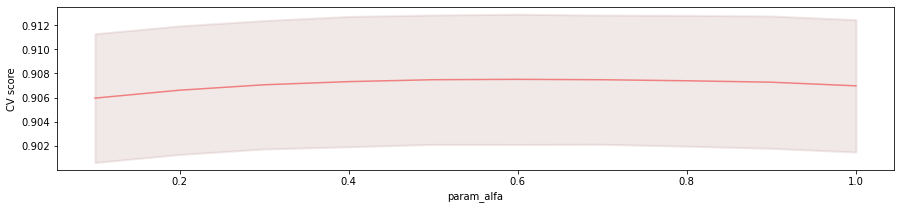

In [285]:
plt.figure(1, figsize=(15, 3))
plt.clf()

C_s = cv_results1['param_alfa']
scores = np.asarray(cv_results1['mean_test_score'])
scores_std = np.asarray(cv_results1['std_test_score'])
minus=scores - scores_std
plus=scores + scores_std
plt.plot(C_s, scores,color='lightcoral')
plt.fill_between(C_s, minus, plus,color='rosybrown', lw=2,alpha=0.2)
plt.ylabel('CV score')
plt.xlabel('param_alfa')
plt.show()

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [310]:
result

,Model,Parameters,Score,Time,OHC,Norm,Mean_test_score,Std_test_score
1,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.834451,0 days 00:05:36.475273,0,1,"[0.6661758739706396, 0.7247047732555478, 0.752...","[0.009314812823255999, 0.007914753976097182, 0..."
2,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.821651,0 days 00:00:04.865232,0,1,"[0.7923512898761016, 0.8104999254441545, 0.803...","[0.7923512898761016, 0.8104999254441545, 0.803..."
3,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.825733,0 days 00:00:08.400102,0,1,"[0.5, 0.5, 0.5, 0.5, 0.7730420620964141, 0.788...","[0.0, 0.0, 0.0, 0.0, 0.00332757902673906, 0.00..."
4,LinearSVC,"LinearSVC(C=1000, class_weight='balanced', dua...",0.825608,0 days 00:00:02.115999,0,1,"[0.8218992831946761, 0.824170125258755, 0.8196...","[0.003583900702052512, 0.0038912635855560228, ..."
5,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.830865,0 days 00:00:03.106524,0,1,"[0.8219069260172608, 0.8232748922285659, 0.824...","[0.0041397340978801545, 0.004083357535711593, ..."
6,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.892096,NaN,1,1,"[0.8879211396183774, 0.8995554482887484, 0.896...",NaN
7,GaussianNB,GaussianNB(var_smoothing=0.12328467394420659),0.892096,NaN,1,1,"[0.8879211396183774, 0.8995554482887484, 0.896...",NaN
8,KNeighborsClassifier,"KNeighborsClassifier(metric='manhattan', n_nei...",0.890718,NaN,1,1,"[0.8887080306259092, 0.8962858188337774, 0.893...",NaN
9,SGDClassifier,"SGDClassifier(loss='log', penalty='l1')",0.900914,NaN,1,1,"[0.8979744368863363, 0.9043602103418056, 0.899...",NaN
10,LogisticRegression,"LogisticRegression(C=0.1, class_weight='balanc...",0.903598,NaN,1,1,"[0.8994992815101188, 0.9097577821574272, 0.903...",NaN


In [315]:
result1.astype({'mean': 'float'})

ValueError: setting an array element with a sequence.

In [313]:
result1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 6 to 12
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Model            7 non-null      object 
 1   Parameters       7 non-null      object 
 2   Score            7 non-null      float64
 3   Time             0 non-null      object 
 4   OHC              7 non-null      object 
 5   Norm             7 non-null      object 
 6   Mean_test_score  7 non-null      object 
 7   Std_test_score   0 non-null      object 
 8   mean             7 non-null      object 
dtypes: float64(1), object(8)
memory usage: 880.0+ bytes


In [316]:
result1.columns

Index(['Model', 'Parameters', 'Score', 'Time', 'OHC', 'Norm',
       'Mean_test_score', 'Std_test_score', 'mean'],
      dtype='object')

KeyError: "None of [Index(['Model', 'Mean_test_score'], dtype='object')] are in the [columns]"

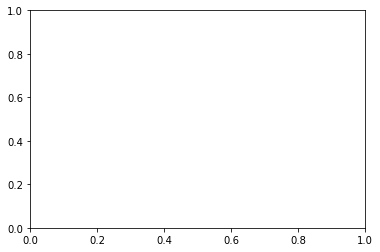

In [308]:

boxplot = df.boxplot(column=['Model', 'Mean_test_score'])

ValueError: List of boxplot statistics and `positions` values must have same the length

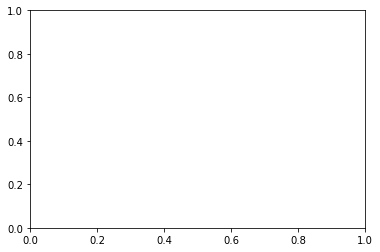

In [304]:
#your code here
import seaborn as sns

colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']

sns.boxplot(x=result1['Model'], y=y1, palette=colors);


boxplot.axes.set_title("диаграмму размаха", fontsize=16)
boxplot.set_xlabel("Модели", fontsize=14)
boxplot.set_ylabel("Качество", fontsize=14);